# 摘要

# 理论模型

豆油是从大豆中提取出来的油脂，具有一定粘稠度，呈半透明液体状，其颜色因大豆种皮及大豆品种不同而异，从淡黄色至深褐色，具有大豆香味。豆油的主要成分为甘三酯，还含有微量磷酯、固醇等成分。甘三酯中含有不饱和脂肪酸中的油酸(21.3%)、亚油酸(54.5%)、亚麻酸和饱和脂肪酸中的硬脂酸(3.5%)、软脂酸(11.7%)及少量的木酸和花生酸。一克豆油的热量约为 9386 卡，消化率高达 98.5%。豆油的酸值一般在 4.0 mg KOH/g 以下,皂化值 190～195mg KOH/g, 凝固点为 -18℃～-15℃，碘价为 120～135(g/100g)。此外，豆油中还富含维生素 E 和维生素 A，其中维生素 E 的含量在所有油脂中是最高的。

![豆油](.\images\豆油.PNG)

## 生产

用压榨法或者浸出法处理后得到杂质较多的毛豆油，然后经过精炼得到可食用的精炼大豆油。

* 压榨法：
    - 普通压榨法：在经过预处理的大豆上加压榨出油脂
    - 螺旋压榨法：在水平的圆筒内安装有螺旋轴，经过预处理的大豆进入圆筒后，在螺旋轴推动下，一边前进一边将油脂挤压出来
* 浸出法：利用能溶解油脂的溶剂，通过润湿渗透、分子扩散和对流扩散的作用，将料坯中的油脂浸提出来，把溶剂和脂肪所组成的混合油进行分离，回收溶剂而得到毛油。应用最普遍的浸出溶剂有己烷或轻汽油等几种脂肪族碳氢化合物，其中轻汽油是应用最多的一种溶剂。浸出法出油率高达 99%。


## 用途

烹饪用油是豆油消费的主要方式。从世界上看，豆油用于烹饪的消费量约占豆油总消费的 70%。从国内看，烹饪用豆油消费约占豆油消费量的 78%，约占所有油类消费的 45%，它和菜籽油一起成为我国烹饪的两大主要用油。

豆油除直接食用外，还可用于食品加工。豆油可以用来制作多种食用油，如凉拌油、煎炸油、起酥油等。此外，豆油还被用于制造人造奶油、蛋黄酱等食品。我国食品加工用油量约占豆油总消费量的 12%。由于餐饮习惯不同，西方国家的比例要高于中国，如美国食品加工用油量约占其国内豆油总消费的 25% 以上。

豆油经过深加工，在工业和医药方面的用途也十分广泛。在工业方面，豆油经过加工可制甘油、油墨、合成树脂、涂料、润滑油、绝缘制品和液体燃料等；豆油脂肪酸中硬脂酸可以制造肥皂和蜡烛；豆油与桐油或亚麻油掺和可制成良好的油漆。在医药方面，豆油有降低血液胆固醇、防治心血管病的功效，是制作亚油酸丸、益寿宁的重要原料。

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

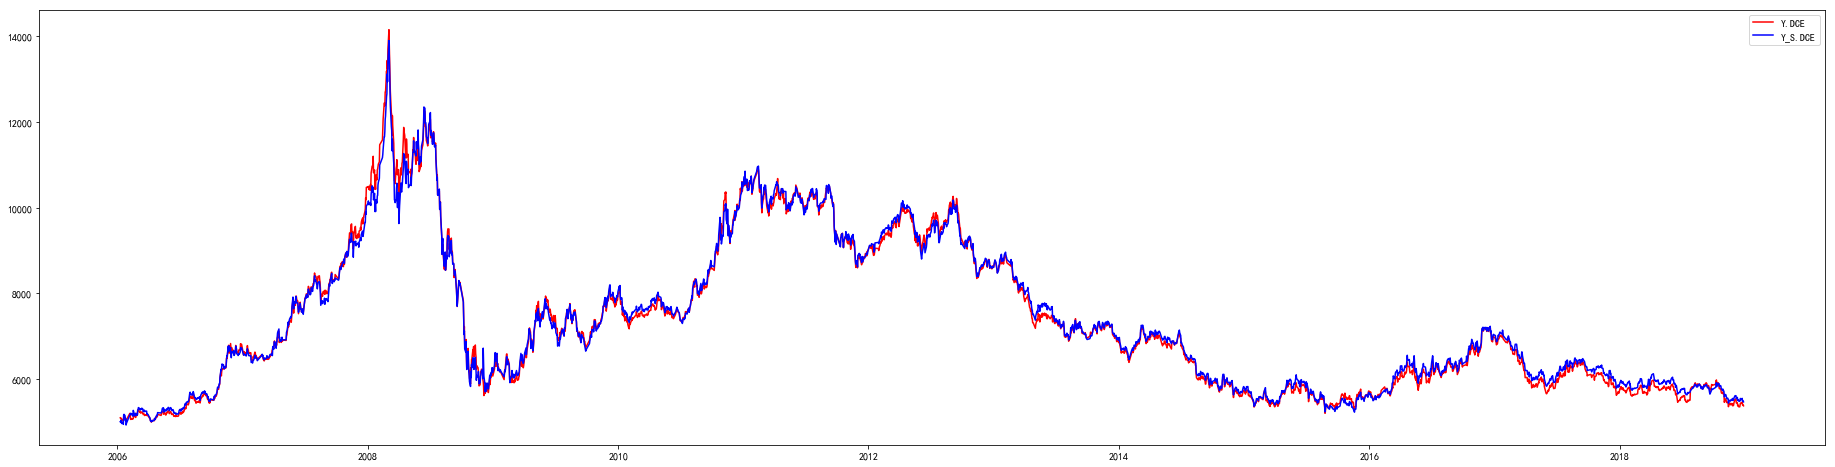

In [2]:
# 参数设置和数据准备
Exchange = "DCE"
MID, SID = "Y.DCE", "Y_S.DCE"# 主力合约, 次主力合约
StartDT = dt.datetime(2006, 1, 9)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
CCPrice = FT.readData(factor_names=[PriceFactor], ids=[MID, SID], dts=DTs).iloc[0]
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
Axes.plot(CCPrice.index, CCPrice.values[:, 0], color='r', label=CCPrice.columns[0])
Axes.plot(CCPrice.index, CCPrice.values[:, 1], color='b', label=CCPrice.columns[1])
Axes.legend(loc='best');

# 附录

## 期货合约

![豆油期货合约](.\images\豆油期货合约.PNG)

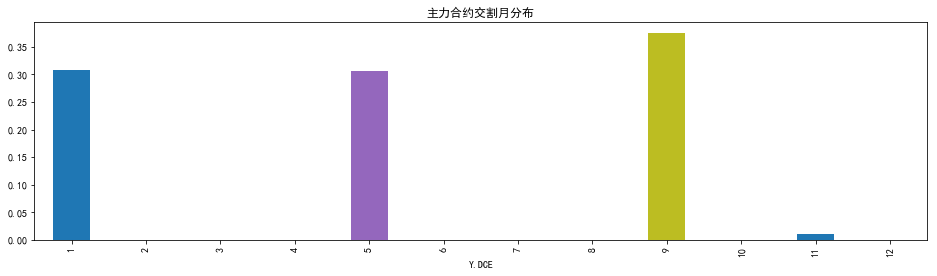

In [3]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

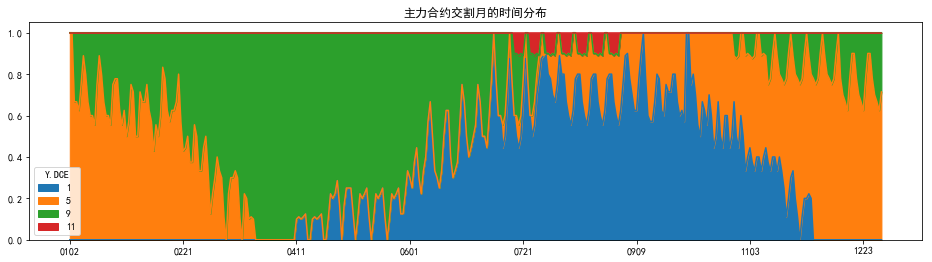

In [4]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);